In [91]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../CH_Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from scipy.optimize import root
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from equilibria_funs import *
from sim_graph_funs import *
figureops = dict(bbox_inches = 'tight', dpi = 600)
colors_x = ['k', 'b', 'r', 'm']

In [115]:
def get_initial_points(num_initial, A, η1, η2,  x_max, H1, H2,**params):
    ''' 
    get initial points to feed to the root finder 
    '''
    α2_1 = params['α2_of_1']
    α1_xm = fun_alpha1(x_max, **params)
    # gx_upper = np.min([
    #     η1 /A * np.sum([fun_alpha1(x,**params) for x in range(1,x_max+1)]),
    #     η2 /A * np.sum([fun_alpha2(x, **params) for x in range(1,x_max+1)]),
    # ])
    gx_upper = 3# try this out
    # Generate random values for N1, N2, and g(x) for each initial point
    np.random.seed(42)
    
    # N1 and N2 are between 0 and 1
    N1_values = np.random.uniform(0, 1, num_initial)  # Shape: (num_initial,)
    N2_values = np.random.uniform(0, 1, num_initial)  # Shape: (num_initial,)
    
    # g(x) is between 0 and gx_upper for each x = 1, 2, ..., x_max
    g_values = np.random.uniform(0, gx_upper, (num_initial, x_max))  # Shape: (num_initial, x_max)
    # Combine N1, N2, and g(x) into a single array
    initial_points = np.hstack((N1_values[:, np.newaxis],  # Add N1 as the first column
                                N2_values[:, np.newaxis],  # Add N2 as the second column
                                g_values))  # Add g(x) as the remaining columns
    
    return initial_points
def get_equilibria_from_init_pts(initial_points, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    results = []
    for i, point in enumerate(initial_points):
        out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq])

            # append new_eq if it's unique from the last one
            if np.any(np.abs(new_eq - curr_eq) > 1e-8):
                results.append([N1_eq, N2_eq, *g_eq, mean_x_eq])
                curr_eq = new_eq
    return results
def get_perturbations(equilibrium, num, strength):
    '''
    @inputs:
    equilibrium - N1, N2, g(1), ... g(x_max)
    num - number of perturbations to return
    TO-DO
    '''

    #  initiate empty array
    perturbations = np.zeros((num, equilibrium.shape[0]))

    # fill array
    for i in range(0,num):
        #perturb
        curr_perturbed = equilibrium + strength * np.random.standard_normal(len(equilibrium))
        curr_perturbed[0:2] = np.clip(curr_perturbed[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
        curr_perturbed[2:] = np.clip(curr_perturbed[2:], a_min = 1e-8, a_max = None)
        perturbations[i,:] = curr_perturbed
    return perturbations

def classify_equilibrium(equilibrium, params):
    '''
    equilibrium = [N1, N2, *gvec]
    '''
    [N1,N2,*gvec] = equilibrium
    J = fun_Jac(N1,N2,gvec,**params)
    stability = classify_stability(J)
    return stability
    # returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)"
    # and "Indeterminate stability (needs further analysis)"

def store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points, 
                                 params, num_perturbations, perturb_strength):
    '''
    iterate through equilibria found for one parameter entry, classify them, 
    and find perturbations for next iteration

    the equilibria given are from solving nullclines iwth N1!=0, N2 != 0
    '''

    def classify_and_store_equilibrium(equilibrium, stable_points, unstable_points):
        # don't need to give it param or params because inside store_equilibria_and_perturb
        result = [param,*equilibrium]
        stability = classify_equilibrium(equilibrium[:-1],params)
        
        if stability == "Stable (attractive)":
            stable_points.append(result)
            
        elif stability == "Unstable":
            unstable_points.append(result)
        return stable_points, unstable_points
    for equilibrium in equilibria:
        # if unique, add to equilibria vector with the param in the first entry

        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points)
        # result = [param, *equilibrium]
        # stability = classify_equilibrium(equilibrium[:-1],params)
        
        # if stability == "Stable (attractive)":
        #     stable_points.append(result)
            
        # elif stability == "Unstable":
        #     unstable_points.append(result)
        
        # get a few perturbations from the equilibrium to generate new points to start from --> aadd this to perturbed pts vector
        perturbed_pts = get_perturbations(np.array(equilibrium[:-1]), 
                                              num_perturbations, perturb_strength)

    # now add on predator extinction equilibria
    g_of_x_extinct = np.zeros(params['x_max'])
    pred_extinct_equilibria = [[1,1,*g_of_x_extinct,0],[1,0,*g_of_x_extinct,0],
                               [0,1,*g_of_x_extinct,0]]

    for equilibrium in pred_extinct_equilibria:
        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points)
    return stable_points, unstable_points, perturbed_pts

def update_params(param_key, param, params_base):
    params = params_base.copy()
        
    if param_key == "scale": # this means β1/β2 = H1/H2 and β2, H2 are set
        params['β1'] = params['β2']*param
        params['H1'] = params['H2']*param
    else:
        params[param_key] = param
    return params
    
    

In [116]:

def get_bif_diagram_input(param_key, param_vec, num_init = 30, num_perturbations = 2,
                          perturb_strength = 0.01, 
                          **params_base):
    '''
    for a parameter that's varied, finds the equilibria and their stability
    '''
    # initiate empty vectors to be filled
    
    # initiate empty perturbed_pts vector, containing points perturbed from the last set of equilibria
    perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])
    
    #initiate empty vectors for stable and unstable pints
    stable_points = []
    unstable_points = []

    for param in param_vec:
        # update param dictionary. if using scaling laws, need to update
    
        # params = params_base.copy()
        # params[param_key] = param
        params = update_params(param_key, param, params_base)
    
        # get some random initial points
        init_pts = get_initial_points(num_initial=num_init,**params.copy())
        init_pts = np.vstack((init_pts,perturbed_pts))
        
        # find equilibria starting from initialpoints and perturbed_pts. already checked for uniqueness
        # each row has N1, N2, g(1), .. g(x_max), \bar{x}
        equilibria = get_equilibria_from_init_pts(init_pts, **params.copy())
        if np.size(equilibria) > 0:
            out = store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points, 
                                           params, num_perturbations, perturb_strength)
            stable_points, unstable_points, perturbed_pts  = out

        # now i need to check predator extinction equilibria
    
    # Convert to numpy arrays for easier manipulation
    stable_points = np.array(stable_points)
    unstable_points = np.array(unstable_points)
    return stable_points, unstable_points
    
def plot_bif_diagram(stable_points, unstable_points, xlab):
    '''
    using the output from get_bif_diagram_input, plots a bifurcation diagram
    '''
    figx, axx = plt.subplots(1,1)
    figN1, axN1 = plt.subplots(1,1)
    figN2, axN2 = plt.subplots(1,1)

    stable_markers = dict(label = "Stable", marker = "o", s = 5, color = "black")
    unstable_markers = dict(label = "Unstable", marker = "*", s = 30, color = "red")
    
    
    if stable_points.size > 0:
        axN1.scatter(stable_points[:, 0], stable_points[:, 1], **stable_markers)
        axN2.scatter(stable_points[:, 0], stable_points[:, 2], **stable_markers)
        axx.scatter(stable_points[:, 0], stable_points[:, -1], **stable_markers)
    
    if unstable_points.size > 0:
        axN1.scatter(unstable_points[:, 0], unstable_points[:, 1], **unstable_markers)
        axN2.scatter(unstable_points[:, 0], unstable_points[:, 2],  **unstable_markers)
        axx.scatter(unstable_points[:, 0], unstable_points[:, -1], **unstable_markers)
    
     
    for ax, ylab in zip([axx, axN1, axN2],[mean_x_lab, N1lab, N2lab]):
        format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True,
             ncol_legend = 1)
    return figx, figN1, figN2

# Type I

In [117]:
H = 0
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [118]:
stable_points, unstable_points = get_bif_diagram_input('β1', np.linspace(1.1,10,30),  
                          **params_base)


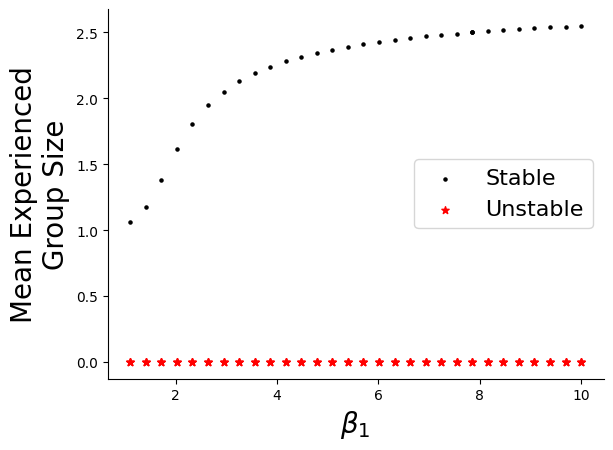

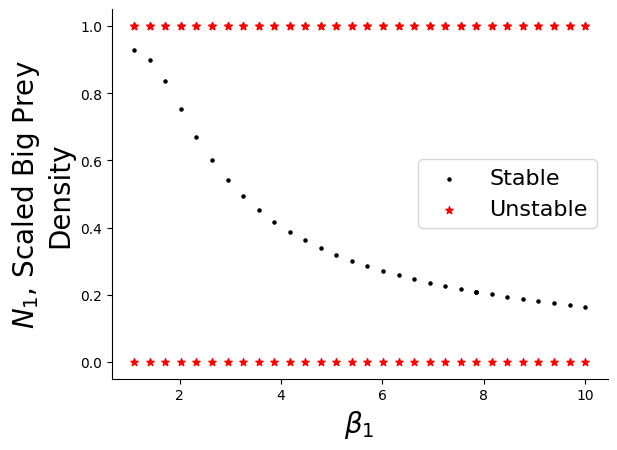

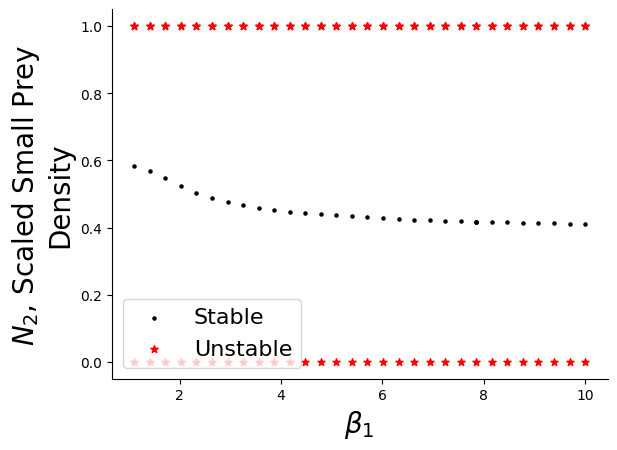

In [119]:
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\beta_1$')

In [120]:
stable_points, unstable_points = get_bif_diagram_input('η1', np.linspace(0.01,params_base['η2'],30),  
                          **params_base)


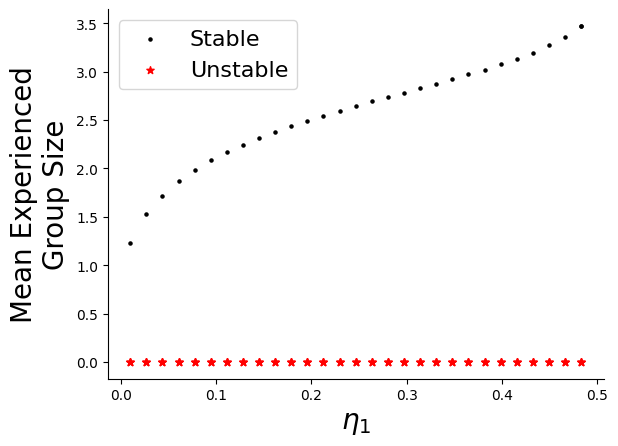

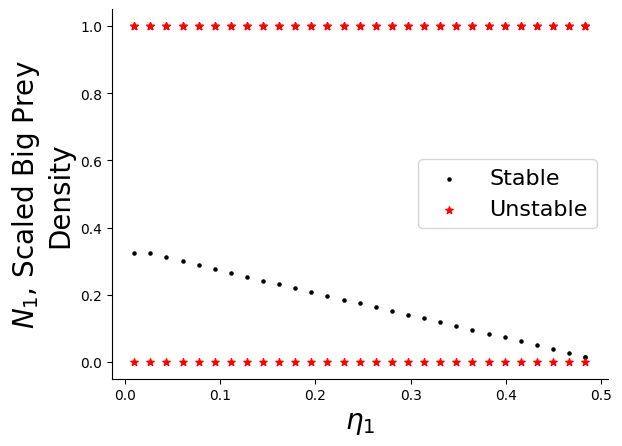

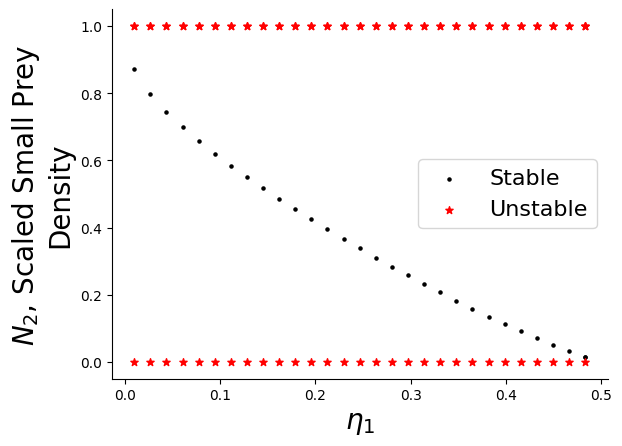

In [121]:
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\eta_1$')

# Type II

In [122]:
H = 2
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

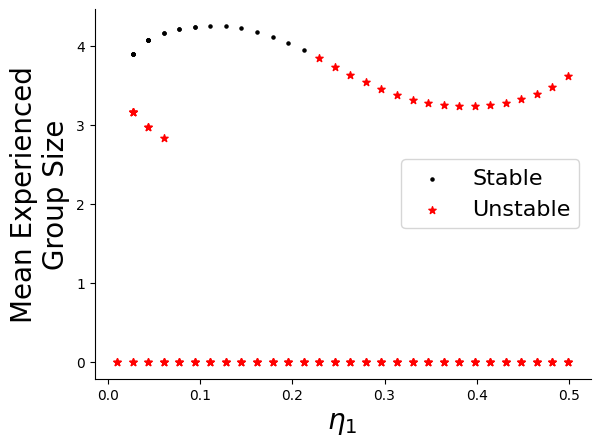

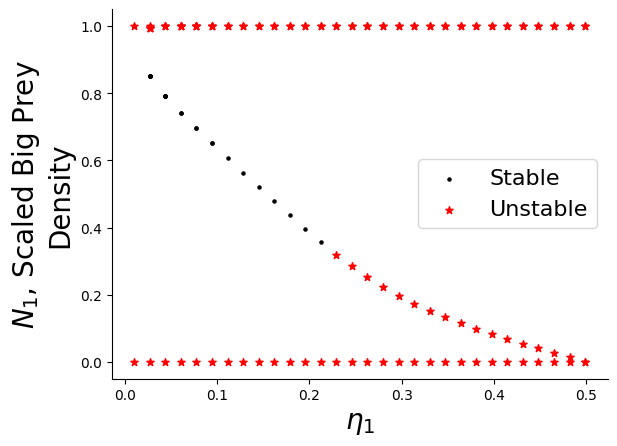

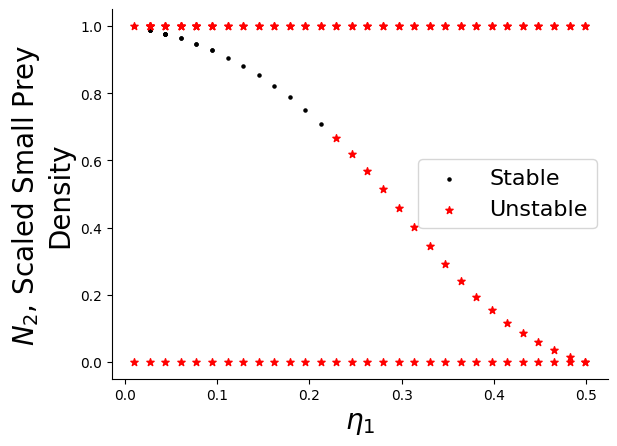

In [123]:
stable_points, unstable_points = get_bif_diagram_input('η1', np.linspace(0.01,params_base['η2']-0.001,30),  
                          **params_base)
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = r'$\eta_1$')

# Type II, $H_1$, $\beta_1$ scaled

In [124]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

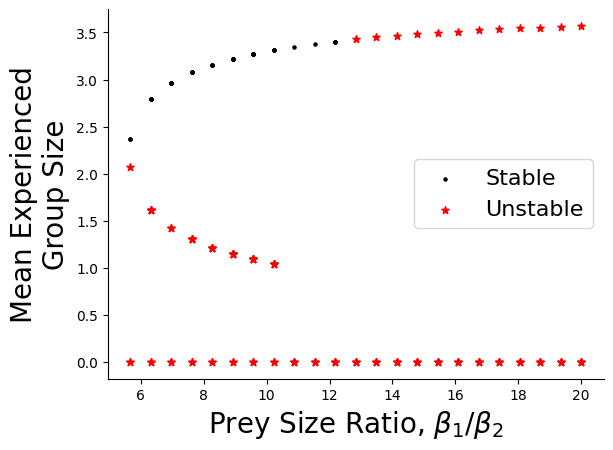

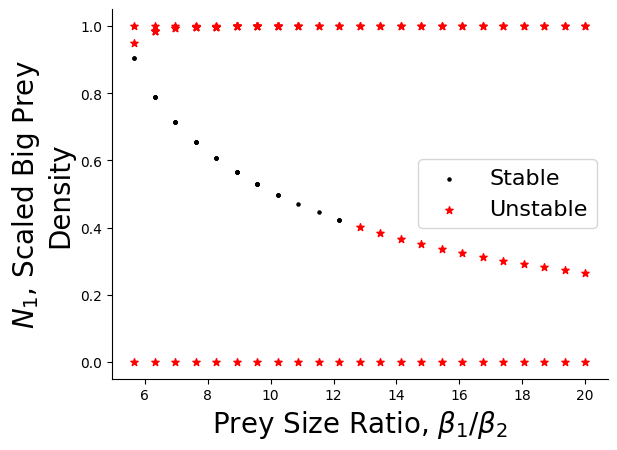

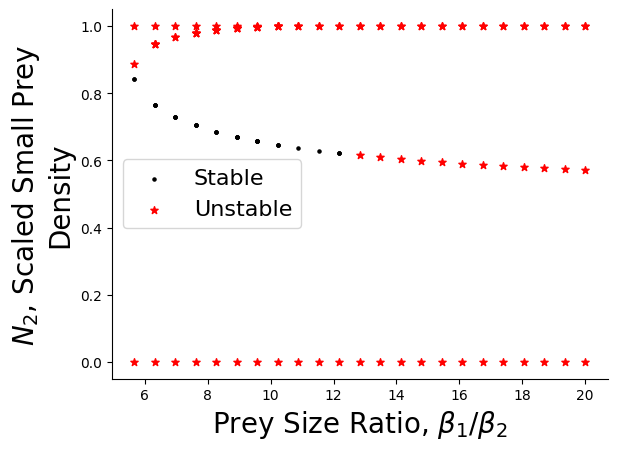

In [125]:
stable_points, unstable_points = get_bif_diagram_input('scale', np.linspace(1.1,20,30),  
                          **params_base, num_init = 40)
figx, figN1, figN2 = plot_bif_diagram(stable_points, unstable_points, xlab = "Prey Size Ratio, " + r'$\beta_1/\beta_2$')

In [165]:
c

[3, 4, 5]

In [162]:
param_vec = np.arange(.02,.4,.01)


In [219]:
'''
pseudocode:
get some random initial points
initiate empty equilibria vector
initiate empty perturbed_pts vector

for some param in a vector of params:
    # update param dictionary. if using scaling laws, need to update
    find equilibria with root starting from initialpoints and perturbed_pts--> equilibria vec
    for each equilibrium:
        add to equilibria vector with the param
        get a few perturbations from the equilibria to generate new points to start from. 
        --> add this to perturbed_pts vector
'''
param_key = 'η1'
param_vec = np.arange(.02,.4,.01) #param_vec = np.arange(2,10,1)
num_init = 30
num_perturbations = 2
perturb_strength = 0.01
# start with params_base



# initiate empty perturbed_pts vector, containing points perturbed from the last set of equilibria
perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])

#initiate empty vectors for stable and unstable pints
stable_points = []
unstable_points = []
for param in param_vec:
    # update param dictionary. if using scaling laws, need to update

    params = params_base.copy()
    params[param_key] = param

    # get some random initial points
    init_pts = get_initial_points(num_initial=num_init,**params.copy())
    init_pts = np.vstack((init_pts,perturbed_pts))
    
    # find equilibria starting from initialpoints and perturbed_pts. already checked for uniqueness
    # each row has N1, N2, g(1), .. g(x_max), \bar{x}
    equilibria = get_equilibria_from_init_pts(init_pts, **params.copy())
    
    out = store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points)
    stable_points, unstable_points, perturbed_pts  = out


# Convert to numpy arrays for easier manipulation
stable_points = np.array(stable_points)
unstable_points = np.array(unstable_points)


    # for equilibrium in equilibria:
    #     # if unique, add to equilibria vector with the param in the first entry
    #     result = [param,*equilibrium]
    #     stability = classify_equilibrium(equilibrium[:-1], params)
    #     if stability == "Stable (attractive)":
    #         stable_points.append(result)
    #     elif stability == "Unstable":
    #         unstable_points.append(equilibrium)
            
    #     # TO-DO: also append stability
        
    #     # get a few perturbations from the equilibrium to generate new points to start from --> aadd this to perturbed pts vector
    #     perturbed_pts = get_perturbations(np.array(equilibrium[:-1]), num_perturbations, perturb_strength)


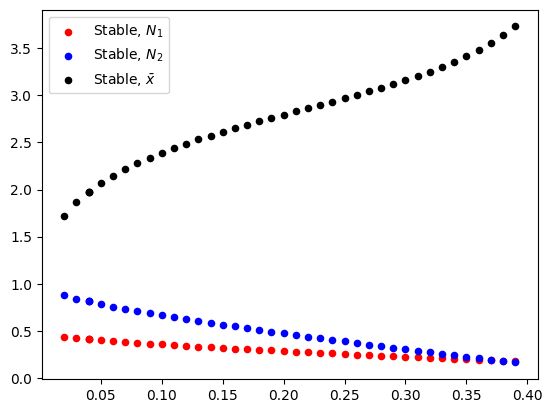

In [221]:
plot_bif_diagram(stable_points, unstable_points)

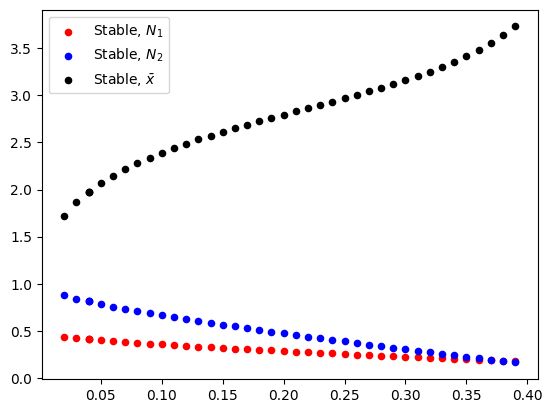

In [220]:
# Plot stable points with circles
stable_markers = dict(marker = "o", s = 20)
unstable_markers = dict(marker = "*", s = 30)
N1_color = "red"
N2_color = "blue"
barx_color = "black"

if stable_points.size > 0:
    plt.scatter(stable_points[:, 0], stable_points[:, 1], label=r'Stable, $N_1$', color=N1_color, **stable_markers)
    plt.scatter(stable_points[:, 0], stable_points[:, 2], label=r'Stable, $N_2$', color=N2_color, **stable_markers)
    plt.scatter(stable_points[:, 0], stable_points[:, -1], label=r'Stable, $\bar{x}$', color=barx_color, **stable_markers)

if unstable_points.size > 0:
    plt.scatter(unstable_points[:, 0], unstable_points[:, 1], label=r'Unstable, $N_1$', 
                color=N1_color, **unstable_markers)
    plt.scatter(unstable_points[:, 0], unstable_points[:, 2], label=r'Unstable, $N_2$', 
                color=N2_color, **unstable_markers)
    plt.scatter(unstable_points[:, 0], unstable_points[:, -1], label=r'Unstable, $\bar{x}$',
                color=barx_color, **unstable_markers)
plt.legend()

In [109]:
perturbed_pts

array([[0.90868345, 0.7151711 , 0.20849154, 0.05064045, 0.00371741,
        0.00310946, 0.        ],
       [0.91618438, 0.72686447, 0.21540857, 0.03391835, 0.        ,
        0.01412193, 0.        ]])

In [6]:



def get_eq_and_update_initial_guess(param, params, x_max, initialpoints, 
                                    results, perturbation_strenth = 0.01):
    '''
    curr_eq = np.zeros(2 + x_max)
    for i, point in enumerate(initial_points):
        out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])
        sol = get_results_eq(out,x_max,tol=1e-8)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol
        
        if success:
            new_eq = np.array([N1_eq, N2_eq, *g_eq])
            
            # append new_eq if it's unique from last one
            if np.any(np.abs(new_eq - curr_eq) > 1e-8):
                results.append((paramvec[0], N1_eq, N2_eq, *g_eq, mean_x_eq))
                curr_eq = new_eq
                
                # perturb and append to initial points
                perturbed_guess = curr_eq + perturbation_strength * np.random.standard_normal(len(curr_eq))
                perturbed_guess[0:2] = np.clip(perturbed_guess[0:2], 
                                               1e-4, 1-1e-4) # make sure 0<N1,N2 <1
                
                initial_points[i] = perturbed_guess
                
    return results, initial_points

β1vec = np.arange(1,10,0.2)


num_initial = 20
perturbation_strength = 0.05
initial_points = get_initial_points(num_initial,**params)
results = []  # To store equilibria
#perturbation_strength = 0.01  # Strength of the perturbation


paramvec = β1vec
param = β1vec[0]
params_updated = params.copy()
params_updated['β1'] = param
curr_eq = np.array([0,0,*np.zeros(params_updated['x_max'])])
for i, point in enumerate(initial_points):
    #print(point)
    out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])
    sol = get_results_eq(out,x_max,tol=1e-8)
    P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol
    if success:
        new_eq = np.array([N1_eq, N2_eq, *g_eq])
        
        # append new_eq if it's unique from last one
        if np.any(np.abs(new_eq - curr_eq) > 1e-8):
            results.append((paramvec[0], N1_eq, N2_eq, *g_eq))
            curr_eq = new_eq
            
            # perturb and append to initial points
            perturbed_guess = curr_eq + perturbation_strength * np.random.standard_normal(len(curr_eq))
            perturbed_guess[0:2] = np.clip(perturbed_guess[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
            
            initial_points[i] = perturbed_guess

# important results from this loop: updated initial_points, updated results, curr_eq


    # now iterate the parameter
    #for the first iteration:
        # use each of the initial points to try to find an equilibrium
        # if it's a success, append it to a results vector
        # also append it to a new initial points vector
        # if say i only have 2 eq from the previous param value, use the 2 eq and n0-2 initial points





    # initiate N1
   

_IncompleteInputError: incomplete input (402760166.py, line 30)

In [32]:
initial_points

array([[2.67101077e-01, 4.73918476e-01, 1.09470488e-01, 1.11707857e-01,
        2.02703813e-01, 4.43817209e-02, 5.08336868e-04],
       [9.50714306e-01, 1.39493861e-01, 5.30095101e-02, 2.49405217e-02,
        4.16115075e-02, 4.37431989e-02, 1.47905125e-02],
       [7.31993942e-01, 2.92144649e-01, 7.75780790e-02, 6.20196666e-02,
        7.51708732e-02, 7.15966249e-02, 4.78389719e-02],
       [5.98658484e-01, 3.66361843e-01, 7.37606911e-02, 7.08043230e-03,
        1.56809148e-02, 3.61871062e-03, 2.60302210e-02],
       [1.56018640e-01, 4.56069984e-01, 3.10987165e-02, 2.17110874e-02,
        6.63086667e-02, 2.85444271e-02, 2.24780375e-02],
       [1.55994520e-01, 7.85175961e-01, 4.34220164e-02, 1.12755817e-02,
        6.41851149e-02, 5.96492102e-03, 7.89624655e-02],
       [5.80836122e-02, 1.99673782e-01, 6.17885886e-02, 1.58995722e-02,
        4.41833777e-04, 6.52464254e-02, 5.65568319e-02],
       [8.66176146e-01, 5.14234438e-01, 5.83290762e-02, 6.17106235e-02,
        5.92443576e-03, 2

In [25]:
np.random.randn?

Signature: np.random.randn(*args)
Docstring:
randn(d0, d1, ..., dn)

Return a sample (or samples) from the "standard normal" distribution.

.. note::
    This is a convenience function for users porting code from Matlab,
    and wraps `standard_normal`. That function takes a
    tuple to specify the size of the output, which is consistent with
    other NumPy functions like `numpy.zeros` and `numpy.ones`.

.. note::
    New code should use the
    `~numpy.random.Generator.standard_normal`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

If positive int_like arguments are provided, `randn` generates an array
of shape ``(d0, d1, ..., dn)``, filled
with random floats sampled from a univariate "normal" (Gaussian)
distribution of mean 0 and variance 1. A single float randomly sampled
from the distribution is returned if no argument is provided.

Parameters
----------
d0, d1, ..., dn : int, optional
    The dimensions of the returned 

In [9]:
num_initial = 10
N1_values = np.random.uniform(0, 1, num_initial)  # Shape: (num_initial,)
N2_values = np.random.uniform(0, 1, num_initial)
gx_upper = 1
x_max = 10
g_values = np.random.uniform(0, gx_upper, (num_initial, x_max))  # Shape: (num_initial, x_max)

In [10]:
    initial_points = np.hstack((N1_values[:, np.newaxis],  # Add N1 as the first column
                                N2_values[:, np.newaxis],  # Add N2 as the second column
                                g_values))  # Add g(x) as the remaining columns

In [11]:
initial_points

array([[0.13905348, 0.21776426, 0.35743241, 0.73112181, 0.09310816,
        0.91665313, 0.67230756, 0.58768687, 0.82399927, 0.92592306,
        0.07768965, 0.80916492],
       [0.20915766, 0.72154784, 0.62207297, 0.72000205, 0.27523373,
        0.89166355, 0.28426668, 0.60508741, 0.16185789, 0.41695741,
        0.96802312, 0.95572721],
       [0.85654959, 0.70113651, 0.78012045, 0.15433558, 0.24615789,
        0.37761587, 0.16797109, 0.89256428, 0.44547212, 0.47712326,
        0.4772136 , 0.73275584],
       [0.07982733, 0.99576069, 0.45167531, 0.33123952, 0.26241432,
        0.66279162, 0.7964743 , 0.75376503, 0.4411495 , 0.39260659,
        0.53556179, 0.55528228],
       [0.92461733, 0.69157874, 0.54024889, 0.28460124, 0.33659654,
        0.26055372, 0.21582682, 0.95136346, 0.39077334, 0.15288086,
        0.19544718, 0.5693397 ],
       [0.28949342, 0.4684703 , 0.51326529, 0.6429784 , 0.16886581,
        0.77524987, 0.59885346, 0.93398947, 0.39037957, 0.35340756,
        0.77266901,